In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from pymc_modeling.model.ols import OLSModel
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)


In [5]:
n_obs = 156
n_features = 3
features = np.random.normal(0, 3, size=(n_obs, n_features))
true_coefs = np.random.normal(1, 5, size=n_features)
true_intercept = 3
y = true_intercept + np.dot(features, true_coefs) + np.random.normal(0, 1, size=n_obs)
feature_names = [f'feature_{i}' for i in range(n_features)]
target_name = 'target'
data = pd.DataFrame(features, columns=feature_names)
data[target_name] = y

In [6]:
model = OLSModel(target_name, feature_names, sampler_config={'draws': 1000, 'tune': 1000, 'target_accept': 0.95, 'chains': 4})

called model config


In [6]:
train = data.sample(frac=0.8).copy()
test = data.drop(train.index).copy()


In [7]:
model.fit(train[feature_names], train[target_name])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, eps, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
Sampling: [b, eps, intercept, target]
Sampling: [target]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


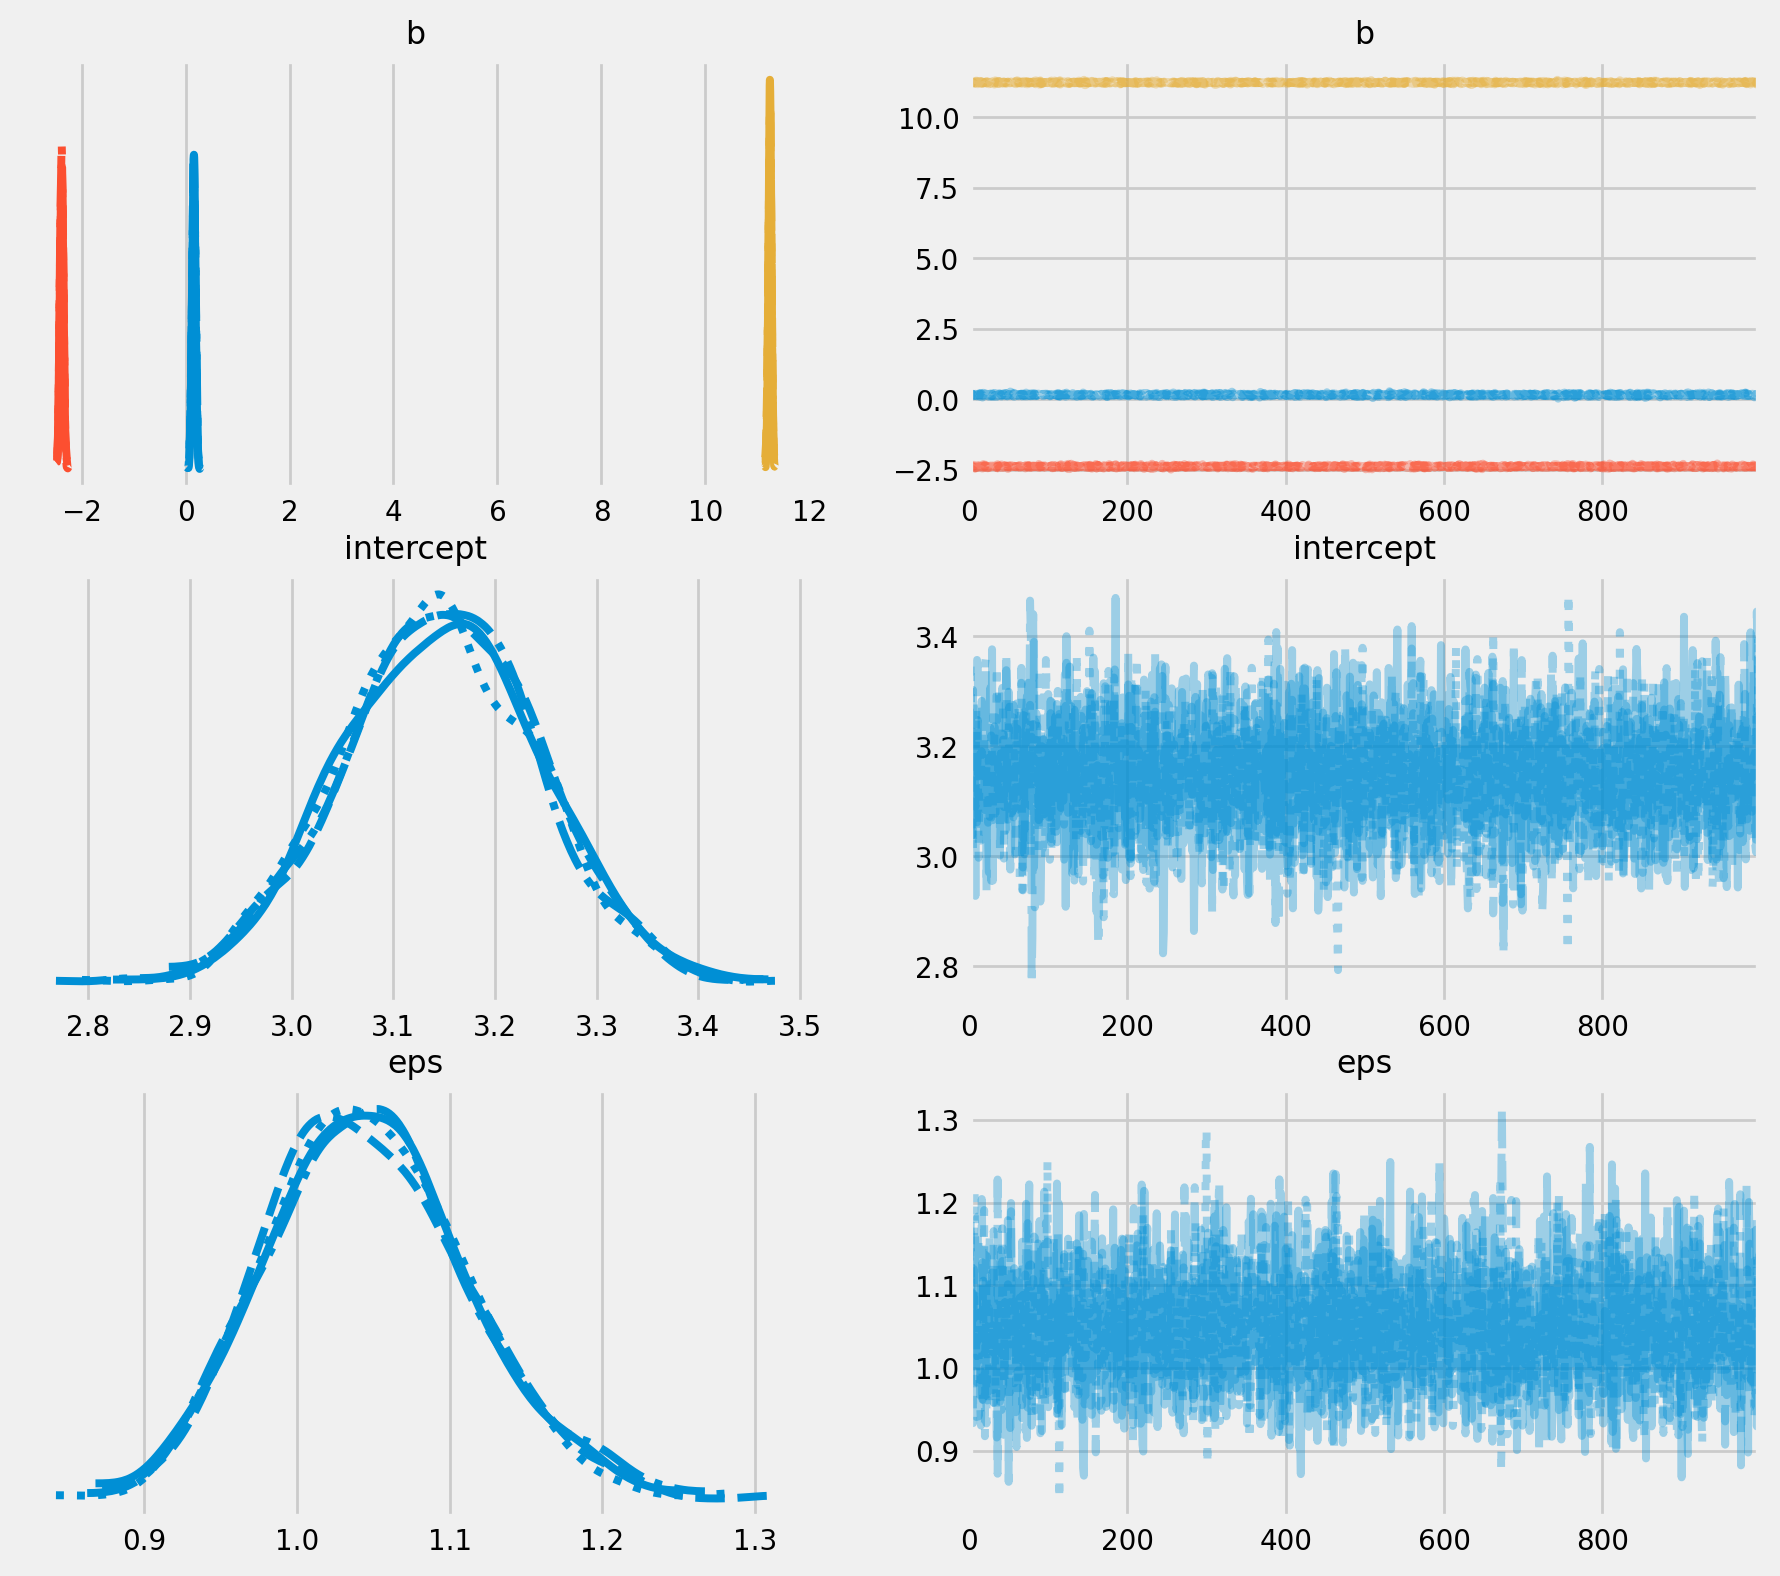

In [8]:
model.plot_trace();

In [9]:
from IPython.display import display, HTML
HTML(model.summary().to_html())

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[feature_0],0.160,0.034,0.096,0.222,0.000,0.000,5575.0,2939.0,1.0
b[feature_1],-2.382,0.033,-2.443,-2.323,0.000,0.000,5766.0,2568.0,1.0
b[feature_2],11.240,0.029,11.183,11.294,0.000,0.000,5877.0,2878.0,1.0
intercept,3.146,0.096,2.955,3.315,0.001,0.001,5722.0,2490.0,1.0
eps,1.047,0.065,0.929,1.170,0.001,0.001,5193.0,3327.0,1.0


In [10]:
true_coefs, true_intercept

(array([ 0.20580464, -2.36672671, 11.24776723]), 3)

In [11]:
test_pred_target = model.predict(test[feature_names])

Sampling: [target]


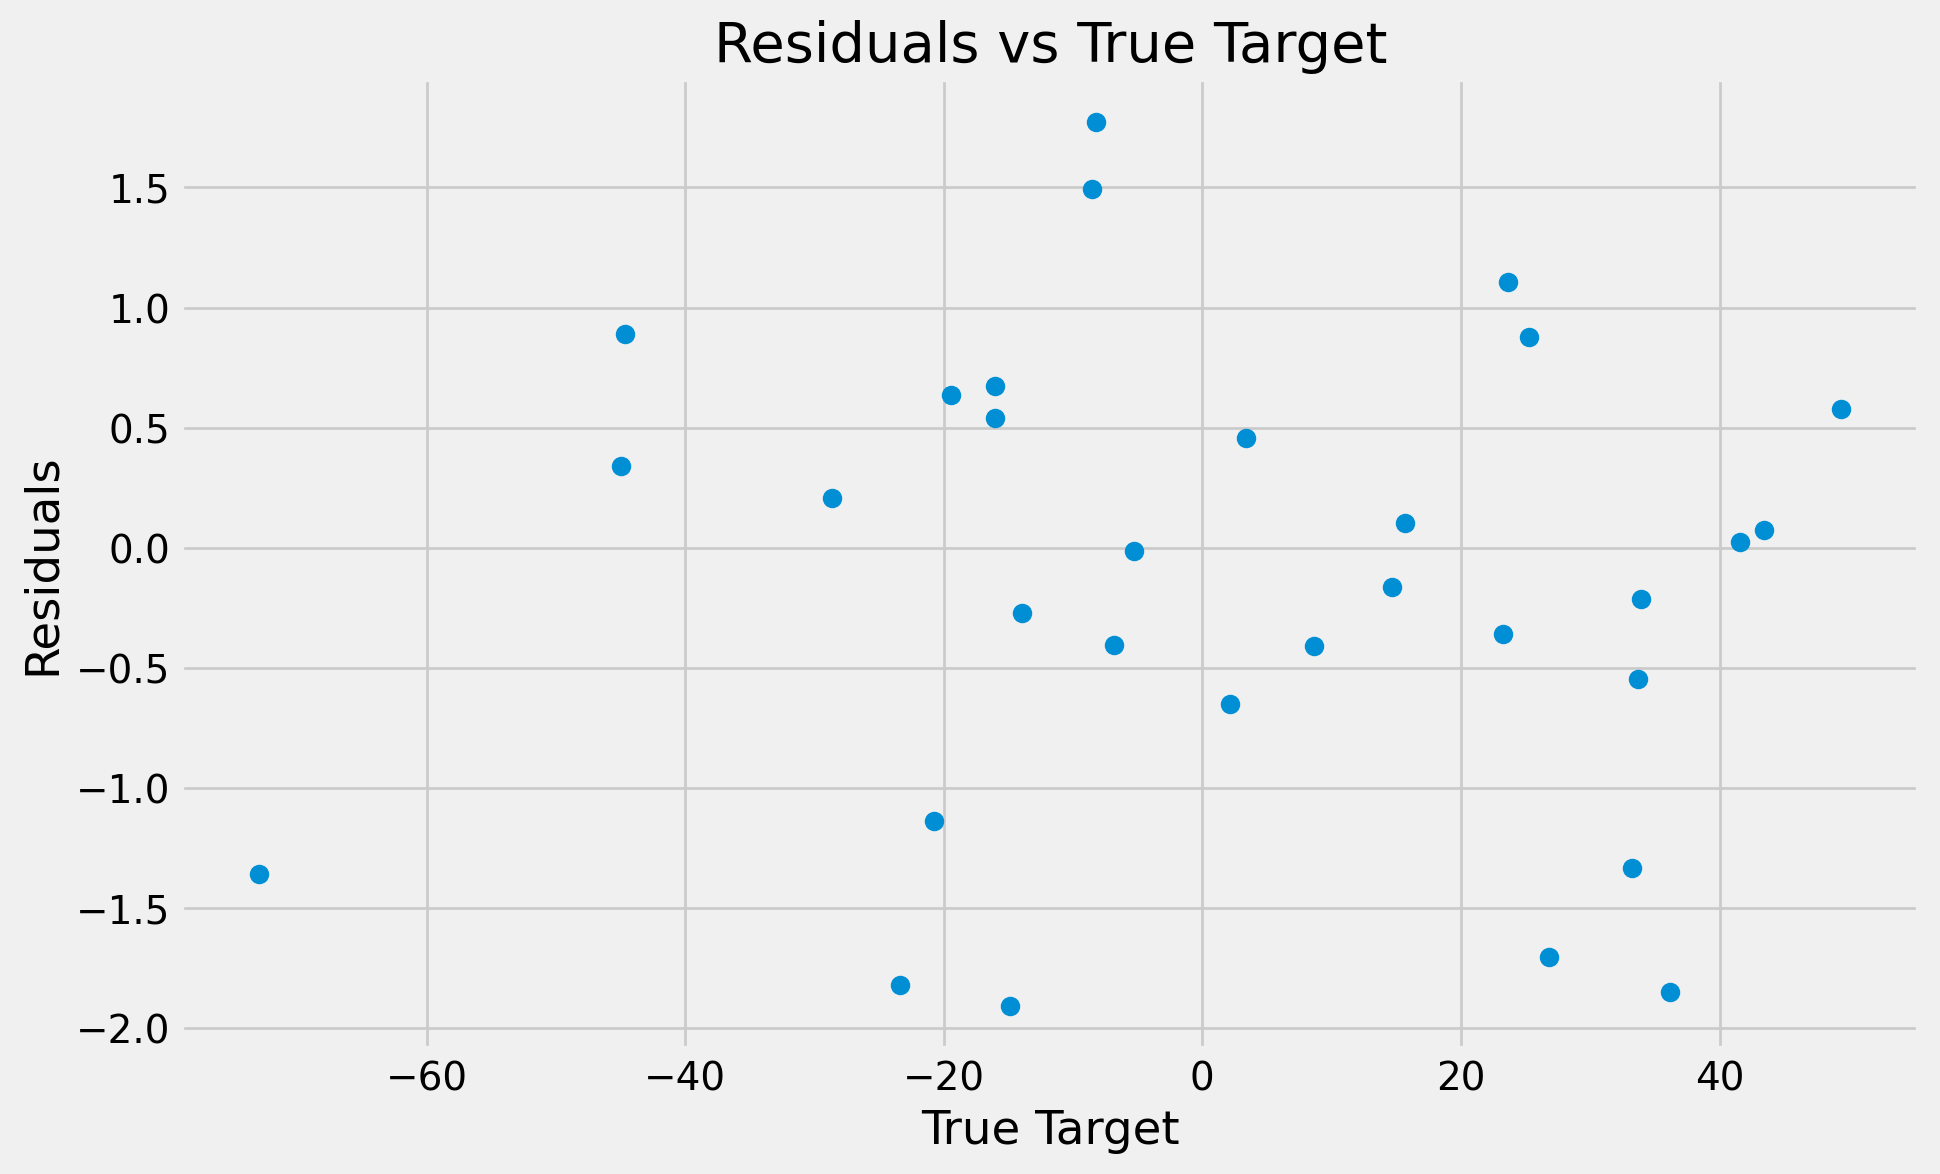

In [12]:
plt.plot(test[target_name], test[target_name]-test_pred_target, 'o');
plt.xlabel('True Target');
plt.ylabel('Residuals');
plt.title('Residuals vs True Target');

In [13]:
fname = "linear_model_v1.nc"
model.save(fname)

In [14]:
test_load = model.load(fname)

/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(


In [16]:
az.summary(test_load.idata.posterior)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[feature_0],0.160,0.034,0.096,0.222,0.000,0.000,5575.0,2939.0,1.0
b[feature_1],-2.382,0.033,-2.443,-2.323,0.000,0.000,5766.0,2568.0,1.0
b[feature_2],11.240,0.029,11.183,11.294,0.000,0.000,5877.0,2878.0,1.0
intercept,3.146,0.096,2.955,3.315,0.001,0.001,5722.0,2490.0,1.0
eps,1.047,0.065,0.929,1.170,0.001,0.001,5193.0,3327.0,1.0


In [17]:
test_load.predict(test[feature_names], extend_idata=False)

Sampling: [target]


array([ 24.36513881,  -6.42166218,  22.51506054, -20.10146428,
        -9.98431342,  34.53309733, -71.55592942,  34.22969092,
        14.82313688, -16.72437639,  43.30595262, -28.84949113,
        23.61169396,  -5.29770672,  48.8230162 , -10.0043175 ,
       -45.55257052, -16.52971364,  37.96644602,   2.9510258 ,
       -45.27786834,  15.58630964, -12.94535274,  34.16840943,
        41.53537864,   9.08773227, -19.61061063, -13.72434352,
       -21.59196103,  28.52387208,   2.78864719])

In [18]:
def loadModule(moduleName, class_name):
    module = None
    try:
        import sys
        del sys.modules[moduleName]
    except BaseException as err:
        pass
    try:
        import importlib
        model = getattr(importlib.import_module(moduleName), class_name)
    except BaseException as err:
        serr = str(err)
        print("Error to load the module '" + moduleName + "': " + serr)
    return model

In [22]:
test_data_no_feature1 = test.copy()
test_data_no_feature1['feature_1'] = 0

In [29]:
predicted_dif = model.predict_posterior(test[feature_names]) - model.predict_posterior(test_data_no_feature1[feature_names])
predicted_dif.mean(dim='sample').sum()

Sampling: [target]


Sampling: [target]


<xarray.DataArray 'target' ()>
array(-22.68733862)

In [19]:
model_graph = model.model_graph()

In [20]:
from PIL import Image
from io import BytesIO

In [30]:
import mlflow
from pymc_modeling.model.ols import OLSModelWrapper
import pandas as pd

def save_model(
    df: pd.DataFrame,
    target_name: str,
    feature_names: list,
    has_intercept: bool = True,
    model_name: str = "model_name",
    eval_data: pd.DataFrame = None,
):
    """
    Runs the Skipgram model using the corpus created and saved by the 'prepare_corpus' function, saves the model and
    returns the trained model. The output of this function is a trained model in binary file format stored as an
    artifact in MLflow tracking server.
    Args:
        df (pd.DataFrame): Dataframe with text content
        model_name (str): Model will be saved with this name as a .bin file
        corpus_filename (str, optional): Name of the .txt file of the corpus. Defaults to 'prepared_corpus'.
        prepared_content (str, optional): Column name for prepared text. Defaults to 'prepared_text'.
    Returns:
        trained_model: Returns the trained model
    """
   
    # Train the model
    model = OLSModel(target_name, feature_names, has_intercept=has_intercept)
    model.fit(df[feature_names], df[target_name])
    dataset = mlflow.data.from_pandas(df, source='generated')

    model_file = model_name + ".nc"
    model.save(model_file)
    # Save the model as an artifact
    artifacts = {"model_path": model_file}

    mlflow_pyfunc_model_path = model_name
    mlflow.set_tracking_uri("http://localhost:5000")
    with mlflow.start_run() as run:
        mlflow.log_input(dataset, "training")
        mlflow.pyfunc.log_model(
            artifact_path=mlflow_pyfunc_model_path,
            python_model=OLSModelWrapper(),
            code_path=["./pymc_modeling/model/ols.py"],
            artifacts=artifacts,
            signature=mlflow.models.infer_signature(df[feature_names], df[target_name]),
        )
        mlflow.log_figure(model.plot_trace(), "trace_plot.png")
        mlflow.log_table(model.summary().reset_index(), 'model_summary.json')
        mlflow.log_text(model.summary().to_string(), 'model_summary.txt')
        mlflow.log_params(model.get_params())
        mlflow.log_image(Image.open(BytesIO(model.model_graph().pipe(format='png'))), "model_graph.png")
        if eval_data is not None:
        
            model_uri = mlflow.get_artifact_uri(mlflow_pyfunc_model_path)
            result = mlflow.evaluate(model_uri, eval_data, 
                        targets=target_name, model_type='regressor', 
                        evaluators=['default'])
        
        
        

    

In [31]:
save_model(data, target_name=target_name, feature_names=feature_names, has_intercept=True, model_name="linear_model_v1", eval_data=test)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, eps, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [b, eps, intercept, target]
Sampling: [target]


/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:143: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]


/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/pydantic/_internal/_config.py:318: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/mlflow/models/evaluation/base.py:414: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(_hash_array_like_element_as_bytes)
/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/mlflow/models/evaluation/base.py:414: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(_hash_array_like_element_as_bytes)
2024/02/27 14:26:23 INFO mlflow

2024/02/27 14:26:24 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/27 14:26:28 INFO mlflow.models.evaluation.default_evaluator: Shap explainer ExactExplainer is used.
fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  32%|███▏      | 10/31 [00:00<?, ?it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  39%|███▊      | 12/31 [00:11<00:09,  2.02it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  42%|████▏     | 13/31 [00:12<00:12,  1.45it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  45%|████▌     | 14/31 [00:13<00:13,  1.30it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  48%|████▊     | 15/31 [00:14<00:13,  1.16it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  52%|█████▏    | 16/31 [00:15<00:13,  1.14it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  55%|█████▍    | 17/31 [00:16<00:12,  1.12it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  58%|█████▊    | 18/31 [00:17<00:11,  1.11it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  61%|██████▏   | 19/31 [00:18<00:10,  1.11it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  65%|██████▍   | 20/31 [00:19<00:10,  1.05it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  68%|██████▊   | 21/31 [00:20<00:09,  1.07it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  71%|███████   | 22/31 [00:21<00:08,  1.08it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  74%|███████▍  | 23/31 [00:22<00:07,  1.06it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  77%|███████▋  | 24/31 [00:23<00:06,  1.05it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  81%|████████  | 25/31 [00:24<00:05,  1.06it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  84%|████████▍ | 26/31 [00:25<00:04,  1.03it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  87%|████████▋ | 27/31 [00:26<00:03,  1.05it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  90%|█████████ | 28/31 [00:27<00:02,  1.04it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  94%|█████████▎| 29/31 [00:27<00:01,  1.05it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer:  97%|█████████▋| 30/31 [00:28<00:00,  1.07it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer: 100%|██████████| 31/31 [00:29<00:00,  1.06it/s]fit_data group is not defined in the InferenceData scheme
Sampling: [target]


fit_data group is not defined in the InferenceData scheme
Sampling: [target]


ExactExplainer explainer: 32it [00:30,  1.40s/it]                        
Unable to serialize underlying model using MLflow, will use SHAP serialization
2024/02/27 14:26:58 WARNING mlflow.models.evaluation.default_evaluator: Logging explainer failed. Reason: TypeError("cannot pickle '_thread.lock' object"). Set logging level to DEBUG to see the full traceback.


In [136]:
model.summary().to_string()

'               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat\nb[feature_0] -1.283  0.036  -1.354   -1.218      0.000    0.000    5955.0    2915.0    1.0\nb[feature_1] -0.043  0.034  -0.104    0.021      0.000    0.000    5255.0    3194.0    1.0\nb[feature_2]  0.129  0.034   0.067    0.195      0.000    0.000    5328.0    2961.0    1.0\nintercept     2.999  0.100   2.809    3.187      0.001    0.001    5064.0    2884.0    1.0\neps           1.107  0.068   0.980    1.233      0.001    0.001    4563.0    3039.0    1.0'

In [119]:
def load_model(self, model_name: str = "model_name", stage: str = "Production"):
    """
    Loads the trained fasttext (Skipgram) model from the model registry and returns
    it as mlflow.pyfunc.PyFuncModel to be used to do the predictions.
    IMPORTANT: The function returns the MLflow model, not the predictions.
    """
    loaded_model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{stage}")

    # Use the abstract function in FastTextWrapper to fetch the trained model.
    fasttext_model = loaded_model.predict(pd.DataFrame([1, 2, 3]))

    self.logger.info("Type of the model is")
    self.logger.info(type(fasttext_model))

    return fasttext_model

In [44]:
model_test = mlflow.pyfunc.load_model("../mlartifacts/0/0b2d031243c848a1b45031039dbfd101/artifacts/linear_model_v1")

/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(


In [48]:
model_test.predict(test)

/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
Sampling: [target]


array([  2.29609574,  27.83687374, -17.43006817,  -1.16108267,
         0.95494854,  31.73830422,  56.00968969,  -9.26800418,
       -16.65748854,  27.90744063,   2.55772691,  -7.6733634 ,
        20.67354777,   3.18900144, -18.32248913, -18.53221352,
         1.04849386,  20.7278062 ,   1.51525578,  23.68121825,
       -29.86381559, -34.07173738,  19.87217509,   7.78883958,
         8.07316101,  27.94651108,  17.66872927,  28.26296056,
       -32.80134099,  -5.28901836, -22.30573703])

In [53]:
model_test.predict(pd.DataFrame(features, columns=feature_names))

/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
Sampling: [target]


array([-1.58027405e+01,  1.83468241e+01,  2.30224920e+00,  2.78304795e+01,
        1.19938686e+01,  6.01632991e+00,  1.56050265e+01, -8.52397276e+00,
        1.82749284e+01,  1.69272300e+01,  7.05534602e+00,  2.04675712e+01,
        8.83312465e+00, -8.92041260e+00,  2.30812972e+01, -4.57911383e+01,
        2.24091027e+01,  1.64707463e+01, -2.54721232e+00, -2.18926202e+01,
       -5.85096482e+01,  1.13823987e+01, -3.15247451e+01, -4.01430342e+01,
        6.29516680e+00, -1.72870930e+01,  4.20093528e+00, -1.74194240e+01,
        1.40202984e+01, -1.12890129e+00, -3.03875112e+01,  7.67866613e+00,
        2.26767111e+01,  9.65096432e-01, -3.44561988e+00,  3.17257556e+01,
        9.86291550e+00,  1.46860943e+01,  1.59761366e+01,  1.80357362e+01,
        1.68330078e+01, -3.06808154e+01,  9.73209543e+00,  5.73151609e+00,
        3.22591691e+01, -3.96266945e-02,  3.34594374e+01,  5.60175456e+01,
        9.30461926e+00, -9.25194392e+00,  1.23532954e+01, -5.02838156e+00,
       -1.66767201e+01, -

# Heirarchical Model

## Data Generation Process

In [225]:
def heirarchical_data_gen(N_samples, N_groups, N_features, target_noise=1, group_heterogeneity=1):

  X = np.random.normal(0, 3, size=(N_samples*N_groups, N_features))
  groups = np.repeat(range(N_groups), N_samples)
  betas = np.random.normal(0, 3, N_features)
  n_corr_coeff = ((N_features-1)*N_features)//2
  corr_coeff = np.random.uniform(-1, 1, size=n_corr_coeff)
  sigmas = np.abs(np.random.normal(2, 1, size=N_features))
  #i, j = np.tril_indices(n=N_features, k=-1, m=N_features)
  #corr_mat = np.identity(N_features)
  #corr_mat[i, j] = corr_coeff
  #corr_mat[j, i] = corr_coeff
  #corr_mat = np.outer(sigmas, sigmas) * corr_mat
  corr_mat = np.array([[sigmas[i]*sigmas[j] if i == j else corr_coeff[i+j-1]*sigmas[i]*sigmas[j] for i in range(N_features)] for j in range(N_features)])
  
  betas_group = np.random.multivariate_normal(np.zeros(shape=N_features), cov=corr_mat, size=(N_groups))
  target_error = np.random.normal(0, 1, size=N_samples*N_groups)

  global_alpha = np.random.normal(0, 1)
  alpha = np.random.normal(0, 1, size=N_groups)*group_heterogeneity + global_alpha
  
  target = alpha[groups] + X @ betas + np.sum(X * betas_group[groups,:], axis=1) + target_noise*target_error

  return X, target, groups, betas, betas_group, alpha, global_alpha, corr_mat, sigmas, corr_coeff


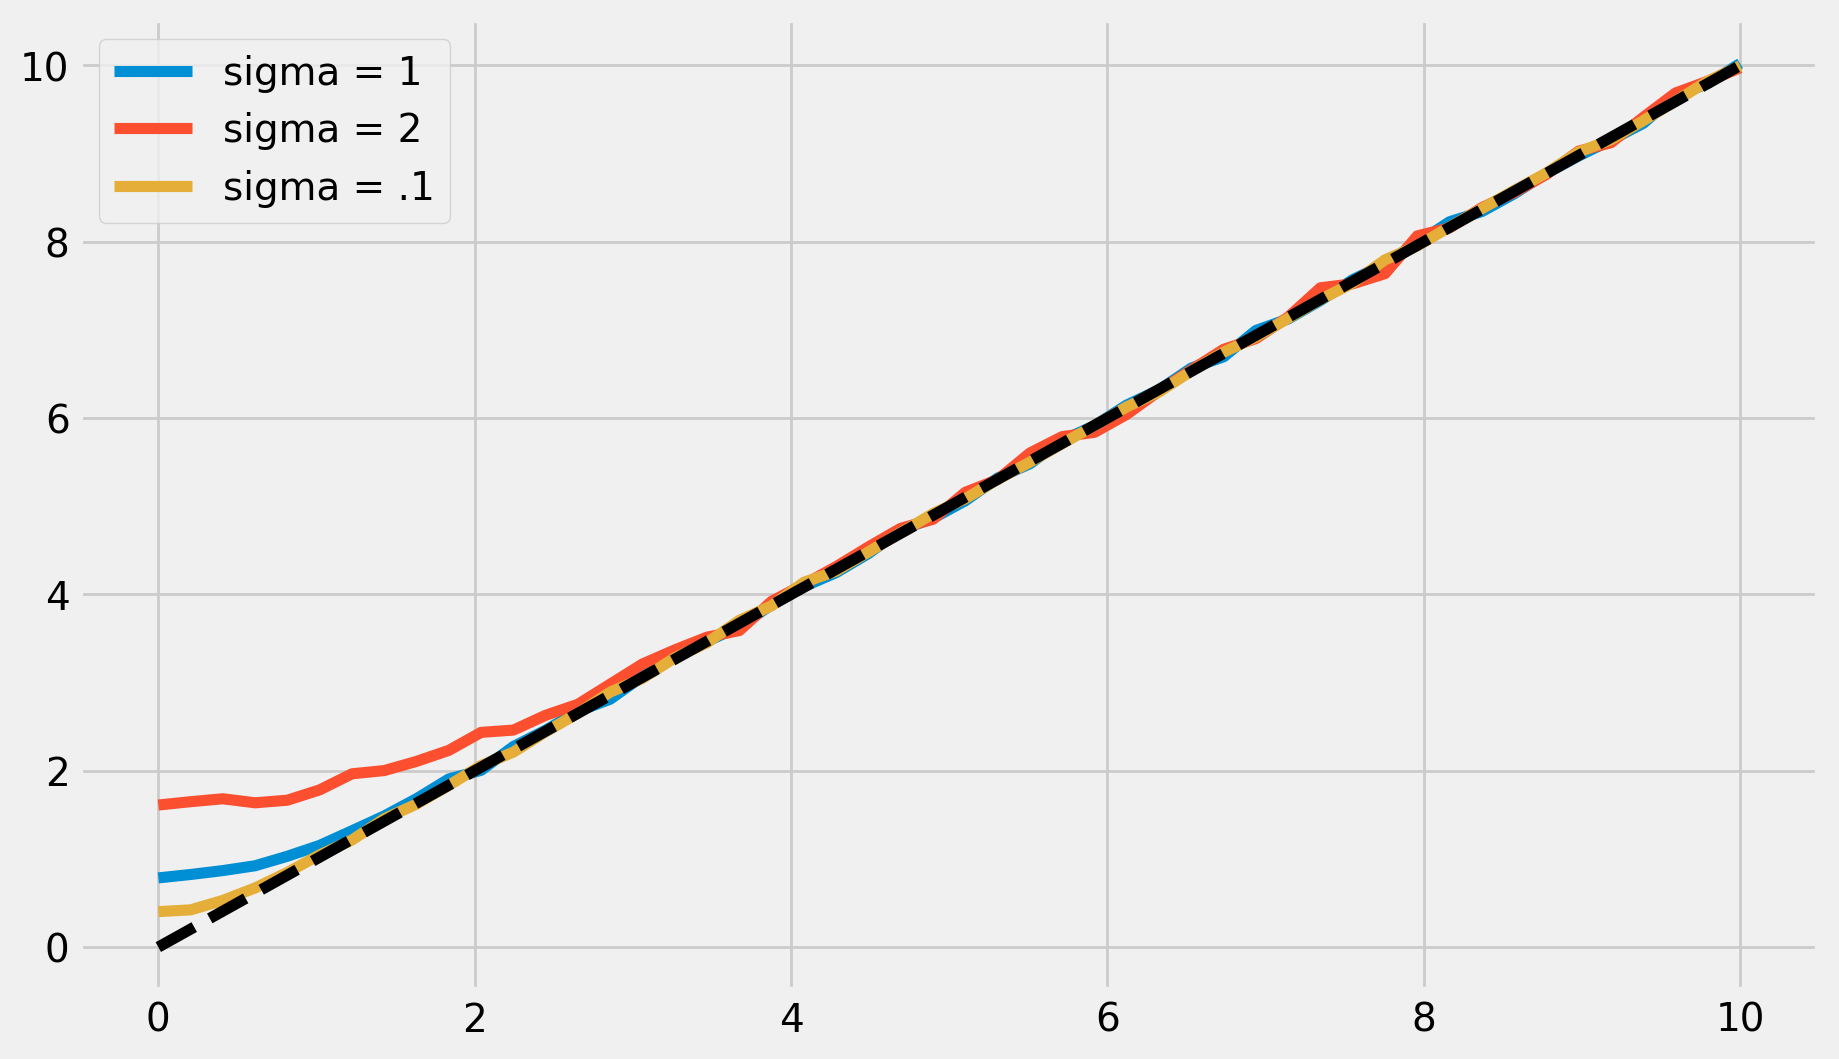

In [250]:
mu = np.linspace(0, 10, 50)
plt.plot(mu, np.abs(np.random.normal(mu, 1, size=(1000, 50))).mean(axis=0), label='sigma = 1')
plt.plot(mu, np.abs(np.random.normal(mu, 2, size=(1000, 50))).mean(axis=0), label='sigma = 2')
plt.plot(mu, np.abs(np.random.normal(mu, .5, size=(1000, 50))).mean(axis=0), label='sigma = .1')
plt.plot(mu, mu, ls='--', c='k')
plt.legend()


$$\int^\infty_{-\infty}N_{\mu,\sigma}(x)|x|dx$$

In [226]:
N_GROUPS = 10
N_SAMPLES = 156
N_FEATURES = 2
X, y, groups, true_betas, true_betas_group, true_alpha, true_global_alpha, *corrs = heirarchical_data_gen(N_SAMPLES, N_GROUPS, N_FEATURES, group_heterogeneity=2, target_noise=2)

In [227]:
np.cov(true_betas_group.T)

array([[37.74725265, 12.38011546],
       [12.38011546,  6.06993551]])

In [228]:
corrs[0]

array([[22.91647203,  4.50421176],
       [ 4.50421176,  4.06573452]])

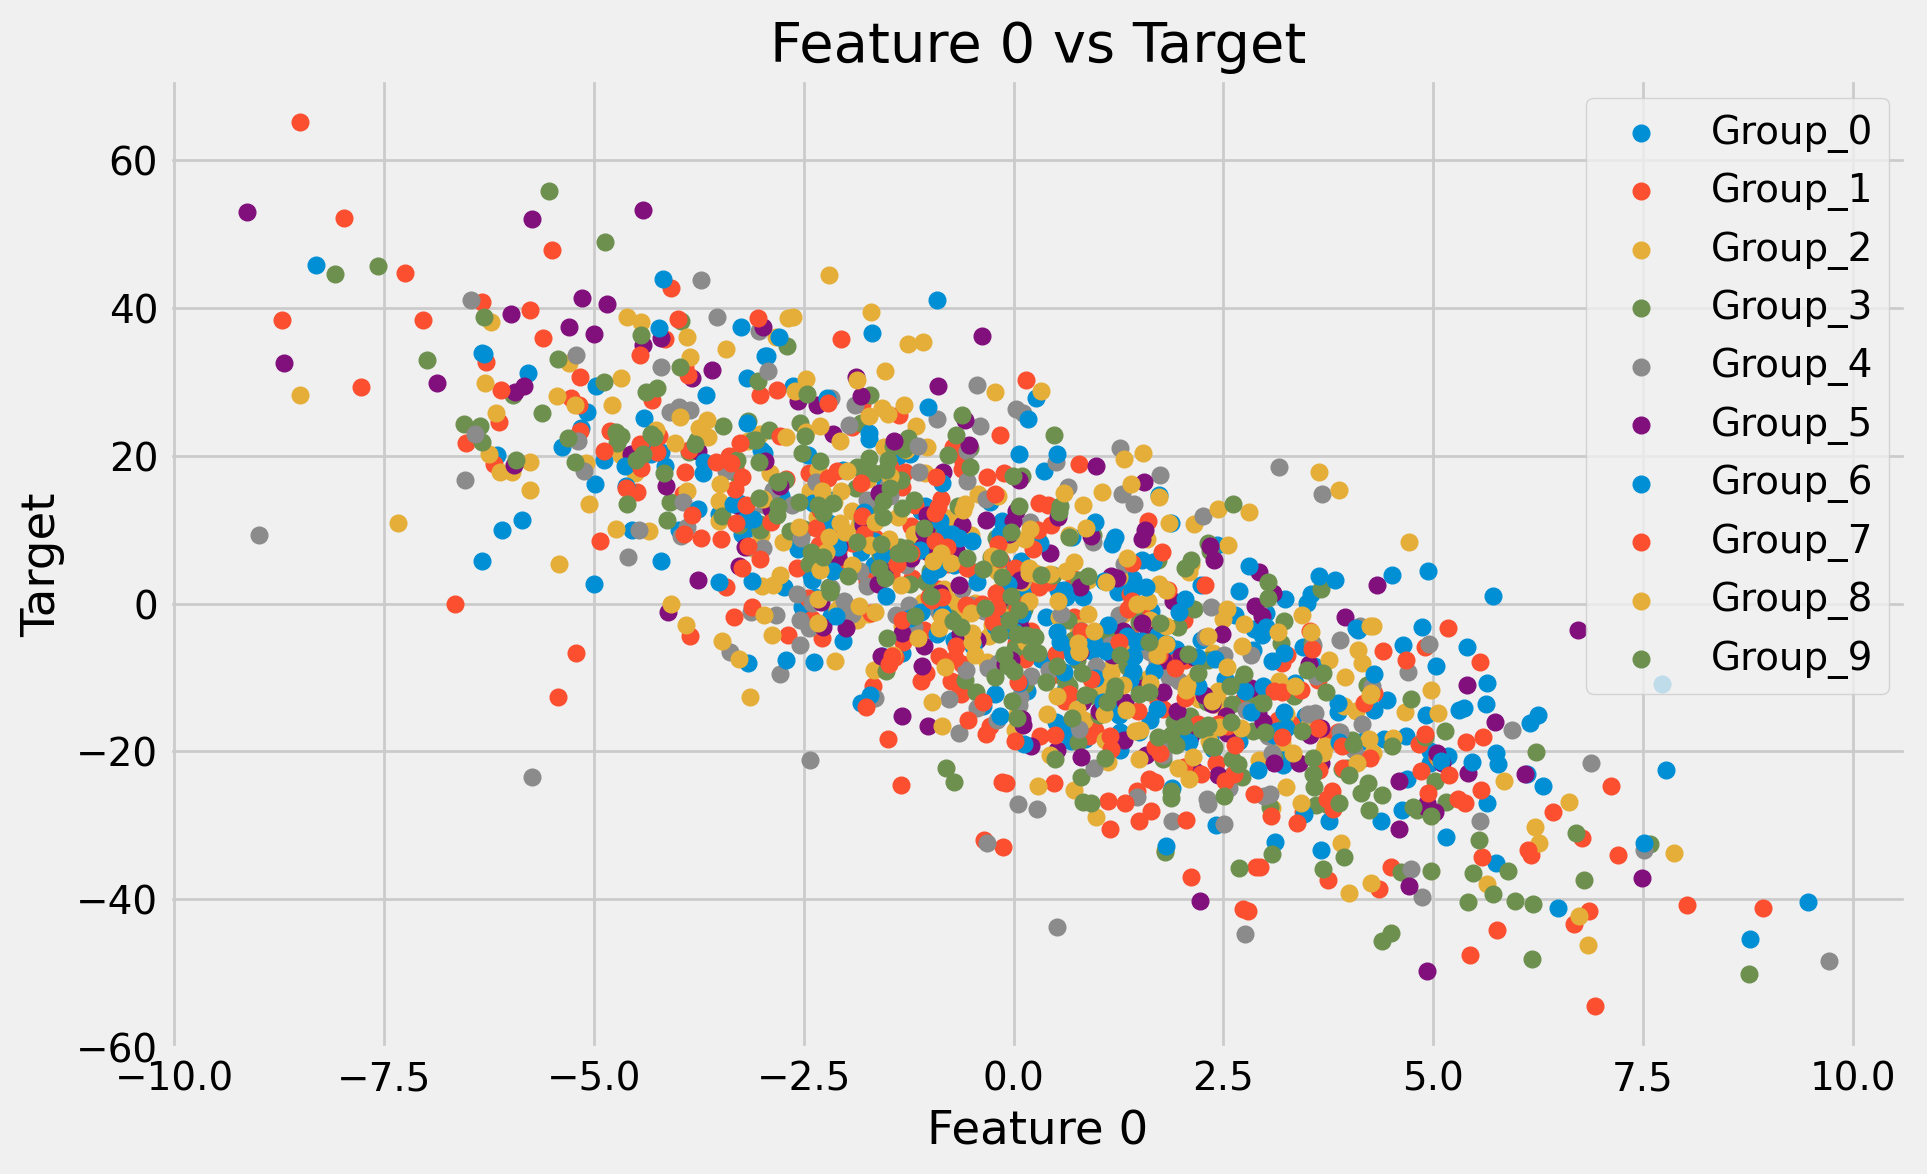

In [224]:
plt.figure(figsize=(10, 6))
for group in range(10):
  plt.scatter(X[groups==group, 1], y[groups==group], label=f'Group_{group}')
plt.title("Feature 0 vs Target")
plt.xlabel('Feature 0')
plt.ylabel("Target")
plt.legend()

In [211]:
with pm.Model(coords=dict(group=np.unique(groups), features=range(N_FEATURES)), coords_mutable=dict(index=range(N_GROUPS*N_SAMPLES))) as heirarchical:
  X_data = pm.MutableData('X_data', X, dims=('index', 'features'))
  group_data = pm.MutableData('groups', groups, dims='index')
  y_data = pm.MutableData('y_data', y, dims='index')
  

  global_betas = pm.Normal('global_beta', 0, 1, dims='features')
  betas_offsets = pm.Normal('beta_offsets', 0, 1, dims=('group', 'features'))
  group_sigma_beta = pm.HalfCauchy('group_sigma_beta', 1, dims='features')
  betas = pm.Deterministic('betas', global_betas + group_sigma_beta * betas_offsets, dims=('group', 'features'))

  global_alpha = pm.Normal('global_alpha', 0, 1)
  alpha_sigma = pm.HalfCauchy("alpha_sigma", 1)
  alpha_offsets = pm.Normal('alpha_offsets', 0, 1, dims='group')
  alpha = pm.Deterministic('alphas', global_alpha + alpha_sigma*alpha_offsets, dims='group')

  noise = pm.HalfCauchy("noise", 1)

  mu = pm.Deterministic('mu', alpha[group_data] + pm.math.sum(X_data*betas[group_data], axis=1), dims='index')
  obs = pm.Normal('obs', mu, noise, observed=y_data)

  trace = pm.sample(1_000, tune=1_500, nuts_sampler='numpyro', target_accept=.95)


Compiling...
Compilation time = 0:00:01.404776
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:01:06.241194
Transforming variables...
Transformation time = 0:00:00.281616


In [213]:
pm.summary(trace, var_names=['betas', 'global_alpha', 'group_sigma_beta', 'alpha_sigma', 'noise'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",-2.380,0.031,-2.437,-2.319,0.000,0.000,6110.0,3584.0,1.00
"betas[0, 1]",-5.813,0.054,-5.916,-5.713,0.001,0.001,4189.0,3483.0,1.00
"betas[1, 0]",-2.379,0.030,-2.432,-2.319,0.000,0.000,7446.0,3268.0,1.00
"betas[1, 1]",-6.191,0.059,-6.305,-6.081,0.001,0.001,4138.0,2909.0,1.00
"betas[2, 0]",-2.392,0.031,-2.452,-2.335,0.000,0.000,4580.0,3475.0,1.00
"betas[2, 1]",-5.663,0.055,-5.766,-5.562,0.001,0.001,3769.0,3327.0,1.00
"betas[3, 0]",-2.382,0.030,-2.440,-2.324,0.000,0.000,6830.0,3095.0,1.00
"betas[3, 1]",-3.470,0.055,-3.570,-3.368,0.001,0.001,4139.0,3189.0,1.00
"betas[4, 0]",-2.371,0.032,-2.431,-2.308,0.000,0.000,5272.0,3302.0,1.00
"betas[4, 1]",-5.157,0.053,-5.256,-5.059,0.001,0.001,3815.0,2825.0,1.00


In [139]:
true_betas + true_betas_group

array([[-1.23810638,  4.16096133],
       [-1.10800867,  3.64637002],
       [-0.98820109,  3.80622438],
       [-1.39942755,  4.19516854],
       [-2.63937411,  3.2002366 ],
       [-1.94510361,  5.52090048],
       [-2.25545007,  4.14860457],
       [-1.35893366,  4.41975054],
       [-2.07340515,  4.25199919],
       [-1.20082475,  4.43887378]])

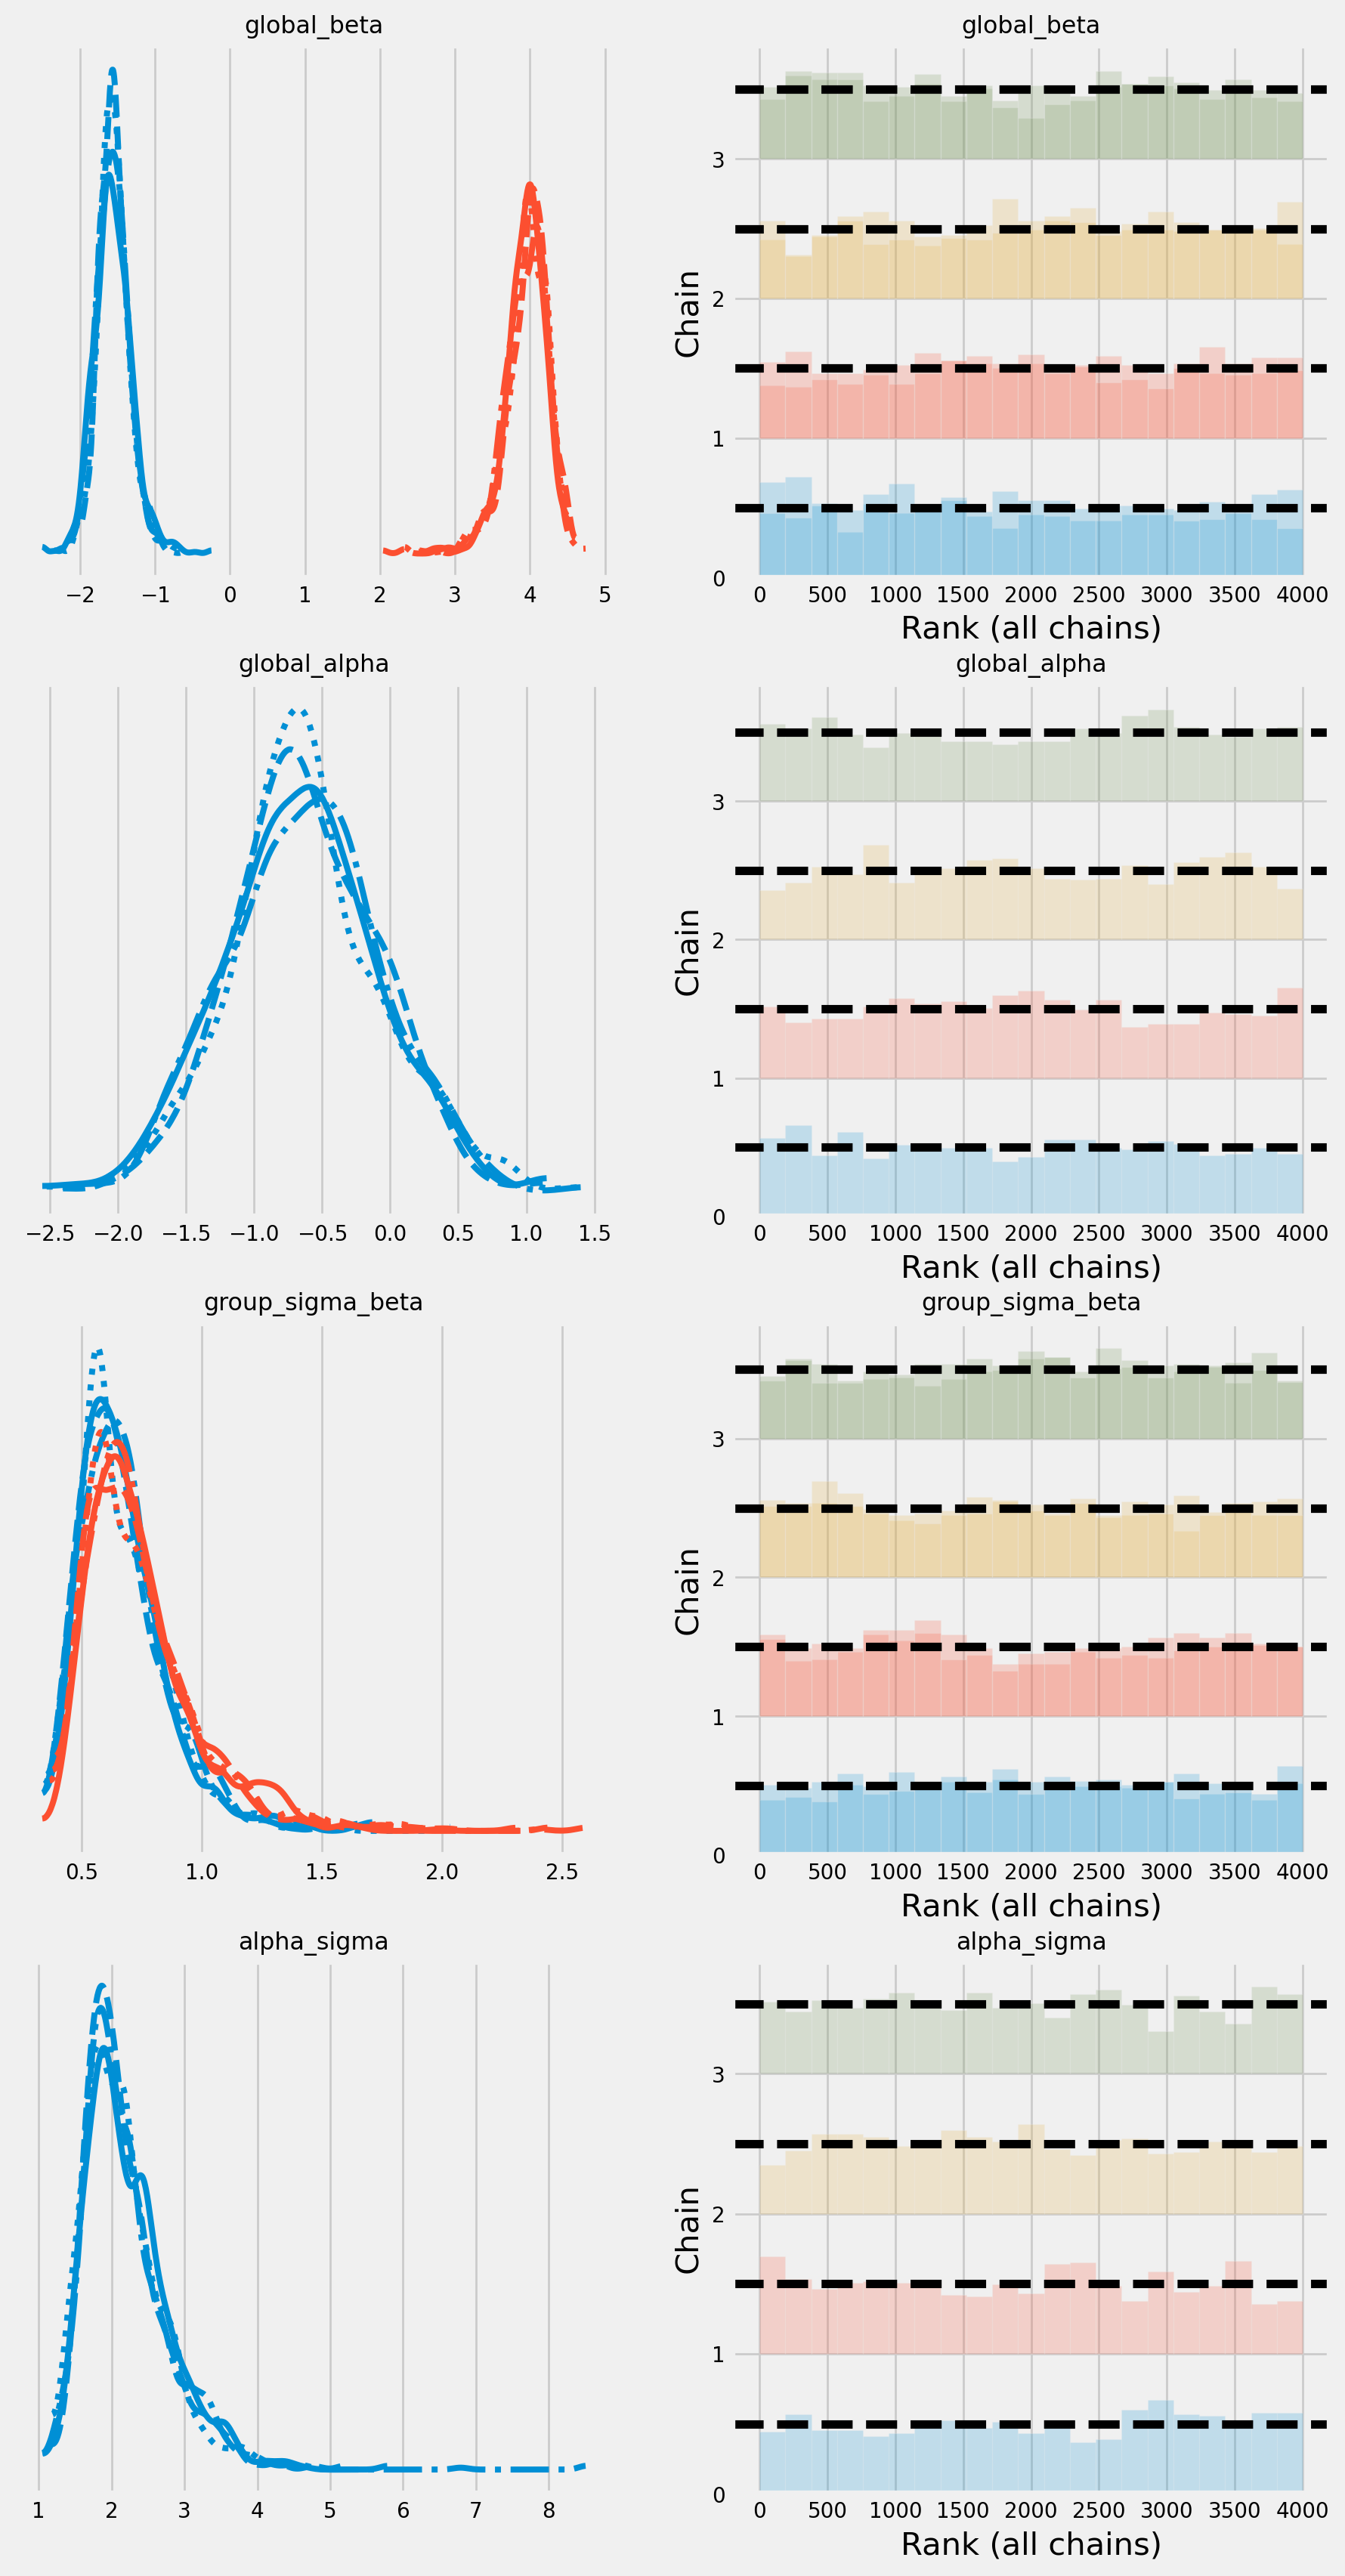

In [135]:
pm.plot_trace(trace, var_names=['global_beta', 'global_alpha', 'group_sigma_beta', 'alpha_sigma'], kind='rank_bars', figsize=(10, 20));

In [137]:
true_betas

array([-1.29177748,  4.23155679])